In [3]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [5]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 5s 136ms/step - loss: 0.0178 - val_loss: 0.0019
Epoch 2/100
16/16 [==============================] - 2s 109ms/step - loss: 0.0017 - val_loss: 3.2168e-04
Epoch 3/100
16/16 [==============================] - 2s 124ms/step - loss: 8.3568e-04 - val_loss: 1.3775e-04
Epoch 4/100
16/16 [==============================] - 1s 77ms/step - loss: 6.7710e-04 - val_loss: 1.7886e-04
Epoch 5/100
16/16 [==============================] - 1s 71ms/step - loss: 5.7197e-04 - val_loss: 1.2009e-04
Epoch 6/100
16/16 [==============================] - 1s 70ms/step - loss: 5.3626e-04 - val_loss: 1.2805e-04
Epoch 7/100
16/16 [==============================] - 1s 72ms/step - loss: 4.8962e-04 - val_loss: 1.1585e-04
Epoch 8/100
16/16 [==============================] - 1s 69ms/step - loss: 4.7421e-04 - val_loss: 1.2240e-04
Epoch 9/100
16/16 [==============================] - 1s 68ms/step - loss: 4.6446e-04 - val_loss: 1.5022e-04
Epoch 10/100
16/16 [=================

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 22ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 23775.693507546734


In [16]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.9991820738639
Testing MAE: 23027.221376443787


In [17]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.23893193900585175], [0.24553371965885162], [0.25290828943252563], [0.2607741057872772], [0.26904037594795227], [0.27767908573150635], [0.2866819202899933], [0.2960476875305176], [0.3057785928249359], [0.31587913632392883], [0.3263552188873291], [0.33721333742141724], [0.3484608232975006], [0.3601049780845642], [0.37215328216552734], [0.38461270928382874], [0.3974900543689728], [0.410791277885437], [0.4245213270187378], [0.4386845827102661], [0.4532835781574249], [0.468319833278656], [0.483792781829834], [0.49970024824142456], [0.51603764295578], [0.5327978730201721], [0.5499715209007263], [0.567546010017395], [0.5855056047439575], [0.6038313508033752], [0.6225003600120544], [0.6414865255355835], [0.6607596278190613], [0.6802855730056763], [0.7000259757041931], [0.7199391722679138], [0.7399789094924927], [0.7600957155227661], [0.7802367806434631], [0.8003460168838501], [0.8203648924827576], [0.8402321934700012], [0.8598862290382385], [0.8792632818222046], [0.8983005285263062], [0.91

In [18]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[ 28479.13637944],
       [ 29083.89183598],
       [ 29759.43856264],
       [ 30479.98588323],
       [ 31237.21673467],
       [ 32028.56488053],
       [ 32853.26863997],
       [ 33711.21881146],
       [ 34602.61741787],
       [ 35527.87669504],
       [ 36487.53719065],
       [ 37482.19405316],
       [ 38512.51887209],
       [ 39579.18050694],
       [ 40682.86419744],
       [ 41824.20877267],
       [ 43003.83668146],
       [ 44222.29393157],
       [ 45480.03370942],
       [ 46777.45733072],
       [ 48114.79684875],
       [ 49492.19149551],
       [ 50909.58940024],
       [ 52366.79127013],
       [ 53863.3766792 ],
       [ 55398.69587823],
       [ 56971.88617496],
       [ 58581.79549304],
       [ 60226.98237201],
       [ 61905.71050721],
       [ 63615.88322887],
       [ 65355.10902303],
       [ 67120.6196304 ],
       [ 68909.29188663],
       [ 70717.60950179],
       [ 72541.75588169],
       [ 74377.49400617],
       [ 76220.29201089],
       [ 780

In [20]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [21]:
print(y_pred_with_test_data.shape)
test_data.shape

(480,)


(480, 1)

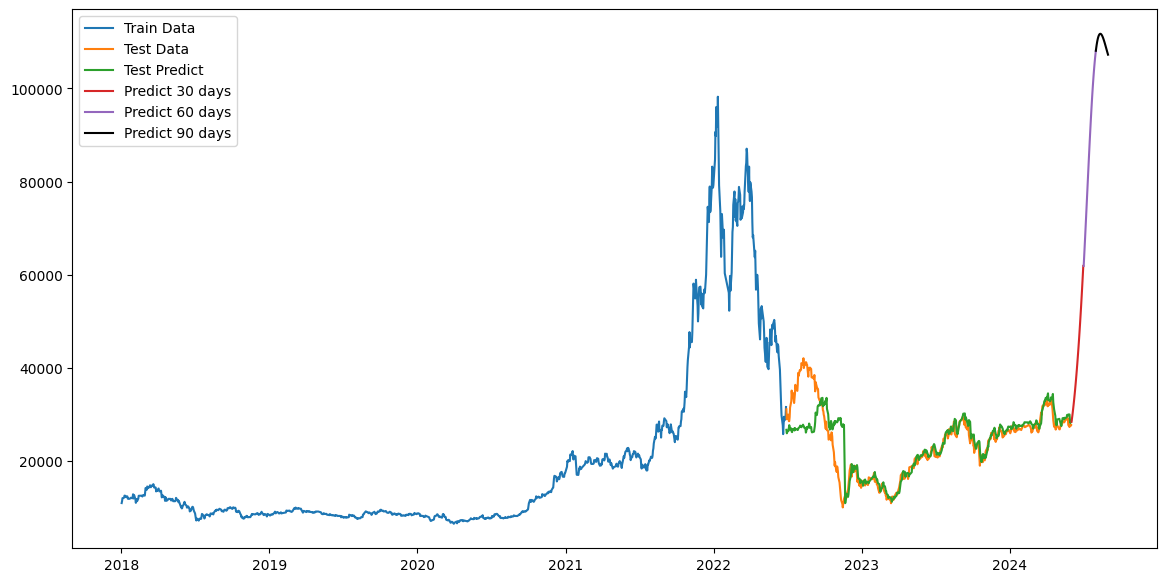

In [23]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()